## Applying Deterministic methods
### Getting started
All exercises rely on chainladder v0.5.5 and later.  There have also been breaking changes with `pandas 1.0` and if you are using an earlier version, date slicing may behave differently.

In [1]:
import pandas as pd
import numpy as np
import chainladder as cl
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
print('chainladder:' + cl.__version__)
print('pandas:' + pd.__version__)

chainladder:0.7.8
pandas:1.0.3


### Basic Chainladder

The basic chainladder method is entirely specified by its development pattern selections.  For this reason, the `Chainladder` estimator takes no additional assumptions, i.e. no additional arguments.

In [2]:
cl.Chainladder()

Chainladder()

Let's start by creating an Triangle with `Development` patterns and a `TailCurve`.  Recall, we can bundle these two estimators into a single `Pipeline` if we wish.

In [3]:
genins = cl.load_sample('genins')

genins_dev = cl.Pipeline(
    [('dev', cl.Development()),
     ('tail', cl.TailCurve())]).fit_transform(genins)

We can now use the basic `Chainladder` estimator to estimate `ultimate_` values of our `Triangle`.

In [4]:
genins_model = cl.Chainladder().fit(genins_dev)
genins_model.ultimate_

,2262
2001,"4,016,553"
2002,"5,594,009"
2003,"5,537,497"
2004,"5,454,190"
2005,"5,001,513"
2006,"5,261,947"
2007,"5,827,759"
2008,"6,984,945"
2009,"5,808,708"
2010,"5,116,430"


We can also view the `ibnr_`.  Techincally the term IBNR is reserved for incurred but not reported, but the `chainladder` models use it to generally describe to amounts out of the lower half of the triangle. 

In [5]:
genins_model.ibnr_

,2262
2001,"115,090"
2002,"254,924"
2003,"628,182"
2004,"865,922"
2005,"1,128,202"
2006,"1,570,235"
2007,"2,344,629"
2008,"4,120,447"
2009,"4,445,414"
2010,"4,772,416"


It is often useful to see the completed `Triangle` and this can be accomplished by inspecting the `full_triangle_`.  As with most other estimator properties, the `full_triangle_` is itself a `Triangle` and can be manipulated as such.

In [6]:
genins_model.full_triangle_.dev_to_val().cum_to_incr()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2262
2001,"357,848","766,940","610,542","482,940","527,326","574,398","146,342","139,950","227,229","67,948",...,,,,,,,,,,"68,482"
2002,,"352,118","884,021","933,894","1,183,289","445,745","320,996","527,804","266,172","425,046",...,"64,913",,,,,,,,,"95,377"
2003,,,"290,507","1,001,799","926,219","1,016,654","750,816","146,923","495,992","280,405",...,"93,678","64,257",,,,,,,,"94,413"
2004,,,,"310,608","1,108,250","776,189","1,562,400","272,482","352,053","206,286",...,"370,179","92,268","63,291",,,,,,,"92,993"
2005,,,,,"443,160","693,190","991,983","769,488","504,851","470,639",...,"226,674","339,456","84,611","58,038",,,,,,"85,275"
2006,,,,,,"396,132","937,085","847,498","805,037","705,960",...,"351,548","238,477","357,132","89,016","61,060",,,,,"89,715"
2007,,,,,,,"440,832","847,631","1,131,398","1,063,269",...,"424,501","389,349","264,121","395,534","98,588","67,626",,,,"99,362"
2008,,,,,,,,"359,480","1,061,648","1,443,370",...,"725,788","508,792","466,660","316,566","474,073","118,164","81,054",,,"119,092"
2009,,,,,,,,,"376,686","986,608",...,"1,089,616","603,569","423,113","388,076","263,257","394,241","98,266","67,405",,"99,038"
2010,,,,,,,,,,"344,014",...,"897,410","959,756","531,636","372,687","341,826","231,882","347,255","86,555","59,371","87,234"


Notice the calendar year of our ultimates.  While ultimates will generally be realized before this date, the `chainladder` package picks the highest allowable date available for its `ultimate_` valuation. 

In [7]:
genins_model.full_triangle_.valuation_date

Timestamp('2262-03-31 23:59:59.999999999')

Another useful property is the `full_expectation_`.  Like the `full_triangle`, it "squares" the `Triangle`, but replaces the known data with the expected implied by the model.

In [8]:
genins_model.full_expectation_

,12,24,36,48,60,72,84,96,108,120,132,9999
2001,"270,061","942,678","1,647,172","2,400,610","2,817,960","3,110,531","3,378,874","3,560,909","3,833,515","3,901,463","3,948,071","4,016,553"
2002,"376,125","1,312,904","2,294,081","3,343,423","3,924,682","4,332,157","4,705,889","4,959,416","5,339,085","5,433,719","5,498,632","5,594,009"
2003,"372,325","1,299,641","2,270,905","3,309,647","3,885,035","4,288,393","4,658,349","4,909,315","5,285,148","5,378,826","5,443,084","5,537,497"
2004,"366,724","1,280,089","2,236,741","3,259,856","3,826,587","4,223,877","4,588,268","4,835,458","5,205,637","5,297,906","5,361,197","5,454,190"
2005,"336,287","1,173,846","2,051,100","2,989,300","3,508,995","3,873,311","4,207,459","4,434,133","4,773,589","4,858,200","4,916,237","5,001,513"
2006,"353,798","1,234,970","2,157,903","3,144,956","3,691,712","4,074,999","4,426,546","4,665,023","5,022,155","5,111,171","5,172,231","5,261,947"
2007,"391,842","1,367,765","2,389,941","3,483,130","4,088,678","4,513,179","4,902,528","5,166,649","5,562,182","5,660,771","5,728,396","5,827,759"
2008,"469,648","1,639,355","2,864,498","4,174,756","4,900,545","5,409,337","5,875,997","6,192,562","6,666,635","6,784,799","6,865,853","6,984,945"
2009,"390,561","1,363,294","2,382,128","3,471,744","4,075,313","4,498,426","4,886,502","5,149,760","5,544,000","5,642,266","5,709,671","5,808,708"
2010,"344,014","1,200,818","2,098,228","3,057,984","3,589,620","3,962,307","4,304,132","4,536,015","4,883,270","4,969,825","5,029,196","5,116,430"


With some clever arithmetic, we can use these objects to give us other useful information.  For example, we can retrospectively review the actual `Triangle` against its modeled expectation.

In [9]:
(genins_model.full_triangle_ - genins_model.full_expectation_).dropna()

,12,24,36,48,60,72,84,96,108
2001,"87,787","182,110","88,158","-182,340","-72,364","209,463","87,462","45,377",0
2002,"-24,007","-76,765","-124,048","9,899","-125,615","-212,094","-58,022","-45,377",
2003,"-81,818","-7,335","-52,380","-74,468","100,960","-155,475","-29,439",,
2004,"-56,116","138,769","-41,694","497,591","203,342","158,105",,,
2005,"106,873","-37,496","77,233","-91,479","-106,323",,,,
2006,"42,334","98,247","22,812","-159,204",,,,,
2007,"48,990","-79,302","29,920",,,,,,
2008,"-110,168","-218,227",,,,,,,
2009,"-13,875",,,,,,,,


Getting comfortable with manipulating `Triangle`s will greatly improve your ability to extract value out of the `chainladder` package.  Here is another way of getting the same answer.

In [10]:
out = (genins - genins_model.full_expectation_)
out[out.valuation<=genins.valuation_date].dropna()

,12,24,36,48,60,72,84,96,108
2001,"87,787","182,110","88,158","-182,340","-72,364","209,463","87,462","45,377",0
2002,"-24,007","-76,765","-124,048","9,899","-125,615","-212,094","-58,022","-45,377",
2003,"-81,818","-7,335","-52,380","-74,468","100,960","-155,475","-29,439",,
2004,"-56,116","138,769","-41,694","497,591","203,342","158,105",,,
2005,"106,873","-37,496","77,233","-91,479","-106,323",,,,
2006,"42,334","98,247","22,812","-159,204",,,,,
2007,"48,990","-79,302","29,920",,,,,,
2008,"-110,168","-218,227",,,,,,,
2009,"-13,875",,,,,,,,


To see the IBNR expected to runoff in the up coming year...

In [11]:
cal_yr_ibnr = genins_model.full_triangle_.dev_to_val().cum_to_incr()
cal_yr_ibnr[cal_yr_ibnr.valuation.year==2011]

,2011
2001,"46,608"
2002,"94,634"
2003,"375,833"
2004,"247,190"
2005,"334,148"
2006,"383,287"
2007,"605,548"
2008,"1,310,258"
2009,"1,018,834"
2010,"856,804"


### The BornhuetterFerguson method
The `BornhuetterFerguson` estimator is another deterministic method having many of the same attributes as the `Chainladder` estimator.  It comes with one assumption, the `apriori`.  This is a scalar multiplier that is to be applied to an exposure vector o determine an apriori ultimate estimate of our model.

Since the CAS Loss Reserve Database has premium, we will use it as an example.  Let's grab the paid loss and net earned premium  for the commercial auto line of business.

In [12]:
comauto = cl.load_sample('clrd').groupby('LOB').sum().loc['comauto'][['CumPaidLoss', 'EarnedPremNet']]
comauto

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(1, 2, 10, 10)"
Index:,[LOB]
Columns:,"[CumPaidLoss, EarnedPremNet]"


Let's set an apriori Loss Ratio estimate of 75%

In [13]:
bf_model = cl.BornhuetterFerguson(apriori=0.75)

The `BornhuetterFerguson` method along with all other expected loss methods like `CapeCod` and `Benktander`, need to take in an exposure vector.  The exposure vector has to be a `Triangle` itself. The `Triangle` class supports single exposure vectors and you can learn more about it in our previous [Triangle tutorial](https://chainladder-python.readthedocs.io/en/latest/tutorials/triangle-tutorial.html#Initializing-a-triangle-with-your-own-data).

The signature for the `fit` function for all estmators is:
```python
estimator.fit(X, y=None, sample_weight)
```
This signature comes from `sklearn` and while we don't use y, the `sample_weight` is used to include an exposure vector for our `BornhuetterFerguson` model.

In [14]:
bf_model.fit(X=comauto['CumPaidLoss'],
             sample_weight=comauto['EarnedPremNet'].latest_diagonal)

BornhuetterFerguson(apriori=0.75, apriori_sigma=0.0, random_state=None)

Having an `apriori` that takes on only a constant for all origins can be limiting.  This shouldn't stop the practitioner from exploiting the fact that the `apriori` can be embedded directly in the exposure vector itself allowing full cusomization of the `apriori`.

In [15]:
b1 = cl.BornhuetterFerguson(apriori=0.75).fit(
    X=comauto['CumPaidLoss'],
    sample_weight=comauto['EarnedPremNet'].latest_diagonal)

b2 = cl.BornhuetterFerguson(apriori=1.0).fit(
    X=comauto['CumPaidLoss'],
    sample_weight=0.75*comauto['EarnedPremNet'].latest_diagonal)

b1.ultimate_ == b2.ultimate_

True

Let's compare the results of our `BornhuetterFerguson` model to our `Chainladder` model.

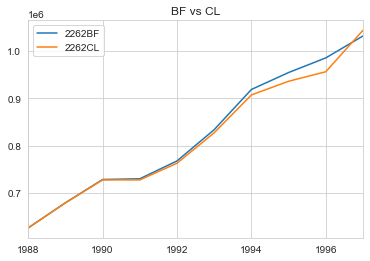

In [16]:
cl_model = cl.Chainladder().fit(comauto['CumPaidLoss'])
bf_model.ultimate_.to_frame().merge(
    cl_model.ultimate_.to_frame(),
    left_index=True, right_index=True,
    suffixes=('BF', 'CL')).plot(title='BF vs CL');

### The Benktander method
The Benktander method is similar to the `BornhuetterFerguson` method, but allows the specification of one additional assumption, `n_iters`.  The Benktander method generalizes both the `BornhuetterFerguson` and the `Chainladder` estimator through this assumption.

* where `n_iters=1` we get the `BornhuetterFerguson` estimator<br>
* where `n_iters` is sufficiently large, we converge to the `Chainladder` estimator.<br>

In [17]:
bk_model = cl.Benktander(apriori=0.75, n_iters=3)

Fitting the `Bentander` method looks identical to the `BornhuetterFerguson` method.

In [18]:
bk_model.fit(X=comauto['CumPaidLoss'],
             sample_weight=comauto['EarnedPremNet'].latest_diagonal)

Benktander(apriori=0.75, apriori_sigma=0, n_iters=3, random_state=None)

Once fit, it has the usual properties we would expect - `ultimate_`, `ibnr_`, `full_triangle_`, and `full_expectation_`.  Let's re-use our same `Chainladder` comparison with the `Benktander` model.  Notice that even at `n_iters=3` it already approximates the `Chainladder` far better than the `BornhuetterFerguson` method.

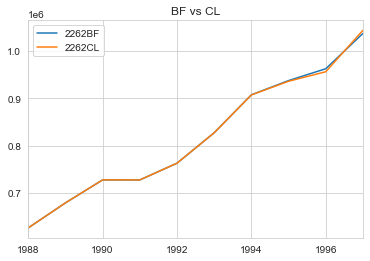

In [19]:
bk_model.ultimate_.to_frame().merge(
    cl_model.ultimate_.to_frame(),
    left_index=True, right_index=True,
    suffixes=('BF', 'CL')).plot(title='BF vs CL');

### Cape Cod method
`CapeCod` is similar to the `BornhuetterFerguson` method except its `apriori` is computed from the `Triangle` itself.  Instead of specifying an `apriori`, you instead specify a `decay` and a `trend`.  

* `decay` is a rate that gives weight to earlier acident periods 
* `trend` is a trend rate along the `origin` axis to reflect possible systematic inflationary impacts on the apriori.

In [20]:
cc_model = cl.CapeCod(decay=1, trend=0).fit(
    X=comauto['CumPaidLoss'],
    sample_weight=comauto['EarnedPremNet'].latest_diagonal)

When you `fit` a `CapeCod`, you can see the `apriori` it computes given the `decay` and `trend` assumptions.  Since it is an estimated parameter, the `CapeCod` attribute is called the `apriori_` with a trailing underscore.

In [21]:
cc_model.apriori_

,2262
1988,0.6857
1989,0.6857
1990,0.6857
1991,0.6857
1992,0.6857
1993,0.6857
1994,0.6857
1995,0.6857
1996,0.6857
1997,0.6857


At a `decay=1`, each `origin` period gets the same `apriori_`.  Let's verify that this `apriori_` makes sense.  It should be the latest incurred losses over the 'used up premium' where 'used up premium' is the premium vector / CDF.

In [22]:
latest_diagonal = comauto['CumPaidLoss'].latest_diagonal

cdf_as_origin_vector = (
    cl.Chainladder().fit(comauto['CumPaidLoss']).ultimate_ / 
    comauto['CumPaidLoss'].latest_diagonal)

used_up_premium = comauto['EarnedPremNet'].latest_diagonal / cdf_as_origin_vector

apriori_check = latest_diagonal.sum() / used_up_premium.sum()
apriori_check

0.6856862224535671

At a `decay=0`, the `apriori_` for each `origin` period stands on its own.

In [23]:
cc_model = cl.CapeCod(decay=0, trend=0).fit(X=comauto['CumPaidLoss'],
             sample_weight=comauto['EarnedPremNet'].latest_diagonal)
cc_model.apriori_

,2262
1988,0.6853
1989,0.7041
1990,0.6903
1991,0.6478
1992,0.6518
1993,0.6815
1994,0.6925
1995,0.7004
1996,0.7039
1997,0.7619


Doing the same on our manually calculated `apriori_` yields the same result.

In [24]:
latest_diagonal / used_up_premium

,1997
1988,0.6853
1989,0.7041
1990,0.6903
1991,0.6478
1992,0.6518
1993,0.6815
1994,0.6925
1995,0.7004
1996,0.7039
1997,0.7619


We can examine our `apriori_` for whether it exhibits any trending over time.

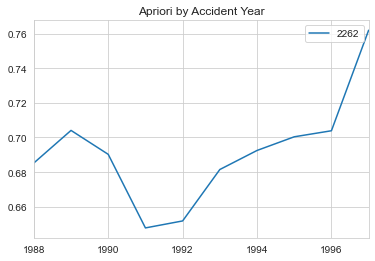

In [25]:
cc_model.apriori_.plot(title='Apriori by Accident Year');

There is not much trend, but lets judgementally flatten it by modifying our `trend` assumption.

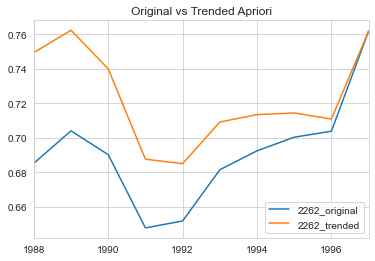

In [26]:
trended_cc_model = cl.CapeCod(decay=0, trend=0.01).fit(
    X=comauto['CumPaidLoss'],
    sample_weight=comauto['EarnedPremNet'].latest_diagonal)

cc_model.apriori_.to_frame().merge(
    trended_cc_model.apriori_.to_frame(),
    left_index=True, right_index=True,
    suffixes=('_original', '_trended')).plot(title='Original vs Trended Apriori');

Adding `trend` to the `CapeCod` method is intended to adjust `apriori_`s to a common level.  Once at a common level, the `apriori_` can be estimated from multiple `origin` periods using the `decay` factor.

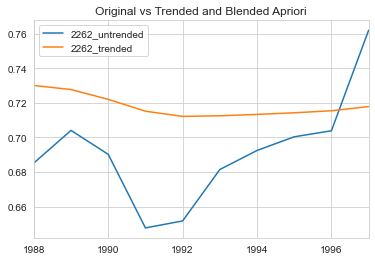

In [27]:
trended_cc_model = cl.CapeCod(decay=0.75, trend=0.01).fit(
    X=comauto['CumPaidLoss'],
    sample_weight=comauto['EarnedPremNet'].latest_diagonal)

cc_model.apriori_.to_frame().merge(
    trended_cc_model.apriori_.to_frame(),
    left_index=True, right_index=True,
    suffixes=('_untrended', '_trended')).plot(title='Original vs Trended and Blended Apriori');

Once estimated, it is necessary to detrend our `apriori_`s back to their untrended levels and these are contained in `detrended_apriori_`. It is the `detrended_apriori_` that gets used in the calculation of `ultimate_` losses.

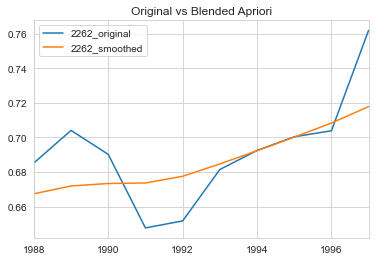

In [28]:
cc_model.apriori_.to_frame().merge(
    trended_cc_model.detrended_apriori_.to_frame(),
    left_index=True, right_index=True,
    suffixes=('_original', '_smoothed')).plot(title='Original vs Blended Apriori');

The `detrended_apriori_` is a much smoother estimate of the initial expected `ultimate_`.  With the `detrended_apriori_` in hand, the `CapeCod` method estimator behaves exactly like our the `BornhuetterFerguson` model.

In [29]:
bf = cl.BornhuetterFerguson().fit(
    X=comauto['CumPaidLoss'],
    sample_weight=trended_cc_model.detrended_apriori_* comauto['EarnedPremNet'].latest_diagonal)
print('BF vs CC Difference: ', bf.ultimate_.sum() - trended_cc_model.ultimate_.sum())

BF vs CC Difference:  0.0


Let's now compare the `CapeCod ultimate_` to the basic `Chainladder` method.

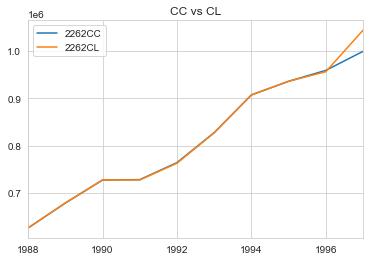

In [30]:
trended_cc_model.ultimate_.to_frame().merge(
    cl_model.ultimate_.to_frame(),
    left_index=True, right_index=True,
    suffixes=('CC', 'CL')).plot(title='CC vs CL');

### Recap
* All the deterministic estimators have `ultimate_`, `ibnr_`, `full_expecation_` and `full_triangle_` attributes that are themselves `Triangle`s.  These can be manipulated in a variety of ways to gain additional insights from your model.<br>
* The expected loss methods take in an exposure vector which itself is a `Triangle` through the `sample_weight` argument of the `fit` method.<br>
* The `CapeCod` method has the additional attributes `apriori_` and `detrended_apriori_` to accomodate the selection of its `trend` and `decay` assumptions.

Finally, these esimators work very well with the transformers discussed in previous tutorials.  Let's go to town demonstating the compositional nature of these estimators.

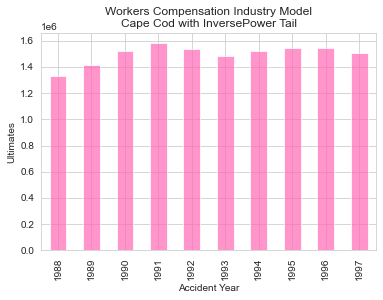

In [31]:
wkcomp = cl.load_sample('clrd').groupby('LOB').sum().loc['wkcomp'][['CumPaidLoss', 'EarnedPremNet']]

patterns = cl.Pipeline([
    ('dev', cl.Development(average=['simple']*5+['volume']*4,
                           n_periods=7, drop_valuation='1995')),
    ('tail', cl.TailCurve(curve='inverse_power', extrap_periods=80)),])

cc = cl.CapeCod(decay=0.8, trend=0.02).fit(
        X=patterns.fit_transform(wkcomp['CumPaidLoss']),
        sample_weight=wkcomp['EarnedPremNet'].latest_diagonal)

cc.ultimate_.plot(kind='bar', color='hotpink', alpha=0.7, legend=False,
                  title='Workers Compensation Industry Model\n' + \
                        'Cape Cod with InversePower Tail').set(
                  xlabel='Accident Year',
                  ylabel='Ultimates');